In [13]:
# The purpose of this project is to perform unsupervised anamoly detection on a dataset
# tha data set looks like this:
"""
;mapped_veh_id;timestamps_UTC;lat;lon;RS_E_InAirTemp_PC1;RS_E_InAirTemp_PC2;RS_E_OilPress_PC1;RS_E_OilPress_PC2;RS_E_RPM_PC1;RS_E_RPM_PC2;RS_E_WatTemp_PC1;RS_E_WatTemp_PC2;RS_T_OilTemp_PC1;RS_T_OilTemp_PC2
0;181;2023-08-01 03:44:12;50.7698183;3.8721144;27.0;23.0;255.0;238.0;794.0;801.0;83.0;81.0;76.0;77.0
1;143;2023-08-01 06:36:29;51.0399934;3.6934285;33.0;32.0;272.0;324.0;802.0;804.0;78.0;78.0;73.0;74.0
2;183;2023-08-24 06:53:54;50.7422026;3.6020347;31.0;33.0;234.0;182.0;799.0;802.0;82.0;82.0;85.0;87.0
"""
# The data is from a fleet of train of the Belgian railway company NMBS/SNCB.
# The data is from the year 2023, and is real data,



'\n;mapped_veh_id;timestamps_UTC;lat;lon;RS_E_InAirTemp_PC1;RS_E_InAirTemp_PC2;RS_E_OilPress_PC1;RS_E_OilPress_PC2;RS_E_RPM_PC1;RS_E_RPM_PC2;RS_E_WatTemp_PC1;RS_E_WatTemp_PC2;RS_T_OilTemp_PC1;RS_T_OilTemp_PC2\n0;181;2023-08-01 03:44:12;50.7698183;3.8721144;27.0;23.0;255.0;238.0;794.0;801.0;83.0;81.0;76.0;77.0\n1;143;2023-08-01 06:36:29;51.0399934;3.6934285;33.0;32.0;272.0;324.0;802.0;804.0;78.0;78.0;73.0;74.0\n2;183;2023-08-24 06:53:54;50.7422026;3.6020347;31.0;33.0;234.0;182.0;799.0;802.0;82.0;82.0;85.0;87.0\n'

In [14]:
# let's start by importing the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import time
import math
import random
import warnings
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
#models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
#validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

# let's use pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.clustering import PowerIterationClustering
from pyspark.ml.clustering import LDA

# let's set some options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# let's set some options for seaborn
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette("Set2")

# let's set some options for matplotlib
plt.rcParams['figure.figsize'] = (12, 8)

# let's set some options for numpy
np.set_printoptions(threshold=sys.maxsize)

# let's set some options for warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# let's set some options for sklearn
np.random.seed(42)

# let's set some options for random
random.seed(42)




In [15]:
# let's define some functions
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

def print_full_columns(x):
    pd.set_option('display.max_columns', len(x))
    print(x)
    pd.reset_option('display.max_columns')

def print_full_rows(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

def print_full_width(x):
    pd.set_option('display.width', len(x))
    print(x)
    pd.reset_option('display.width')

def print_full_numpy(x):
    np.set_printoptions(threshold=sys.maxsize)
    print(x)


# let's define some functions for pyspark
def print_full_spark(x):
    print(x.toPandas())

def print_full_spark_columns(x):
    pd.set_option('display.max_columns', len(x.columns))
    print(x.toPandas())
    pd.reset_option('display.max_columns')

def print_full_spark_rows(x):
    pd.set_option('display.max_rows', len(x.columns))
    print(x.toPandas())
    pd.reset_option('display.max_rows')

def print_full_spark_width(x):
    pd.set_option('display.width', len(x.columns))
    print(x.toPandas())
    pd.reset_option('display.width')


# let's define some functions for plotting
def plot_hist(x, title, xlabel, ylabel, bins, color):
    plt.hist(x, bins=bins, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_hist_log(x, title, xlabel, ylabel, bins, color):
    plt.hist(x, bins=bins, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.show()

def plot_hist_norm(x, title, xlabel, ylabel, bins, color):
    plt.hist(x, bins=bins, color=color, density=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_hist_norm_log(x, title, xlabel, ylabel, bins, color):
    plt.hist(x, bins=bins, color=color, density=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.show()

def plot_hist_norm_cum(x, title, xlabel, ylabel, bins, color):
    plt.hist(x, bins=bins, color=color, density=True, cumulative=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()



# let's define some functions for pyspark plotting
def plot_hist_spark(x, title, xlabel, ylabel, bins, color):
    plt.hist(x, bins=bins, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_hist_spark_log(x, title, xlabel, ylabel, bins, color):
    plt.hist(x, bins=bins, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.show()

def plot_hist_spark_norm(x, title, xlabel, ylabel, bins, color):
    plt.hist(x, bins=bins, color=color, density=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_hist_spark_norm_log(x, title, xlabel, ylabel, bins, color):
    plt.hist(x, bins=bins, color=color, density=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.show()

def plot_hist_spark_norm_cum(x, title, xlabel, ylabel, bins, color):
    plt.hist(x, bins=bins, color=color, density=True, cumulative=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()




In [21]:
# let's read x% of the data set
x = 1
df = pd.read_csv('ar41_for_ulb_mini.csv', sep=';')
df = df.sample(frac=x, random_state=42).reset_index(drop=True)
#drop the first column
df = df.drop(df.columns[0], axis=1)
# let's print the shape of the data set
print_full('The shape of the data set is: {}'.format(df.shape))

# let's print the head of the data set
print_full(df.head())



The shape of the data set is: (100, 14)
   mapped_veh_id       timestamps_UTC        lat       lon  \
0            116  2023-08-01 15:53:39  50.811119  3.617022   
1            170  2023-08-01 10:05:05  50.996628  3.649726   
2            181  2023-08-24 19:17:45  51.246008  5.541184   
3            188  2023-08-01 08:26:25  50.392878  4.401183   
4            106  2023-08-01 08:26:06  50.508627  4.219383   

   RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  RS_E_OilPress_PC1  \
0                40.0                35.0              200.0   
1                38.0                34.0              203.0   
2                34.0                39.0              231.0   
3                42.0                36.0              303.0   
4                26.0                28.0              279.0   

   RS_E_OilPress_PC2  RS_E_RPM_PC1  RS_E_RPM_PC2  RS_E_WatTemp_PC1  \
0              165.0         796.0         794.0              83.0   
1              246.0         799.5         801.0              

C:\Users\nouss\AppData\Local\Temp\ipykernel_4988\3750650479.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamps_UTC'] = pd.to_datetime(df['timestamps_UTC'])


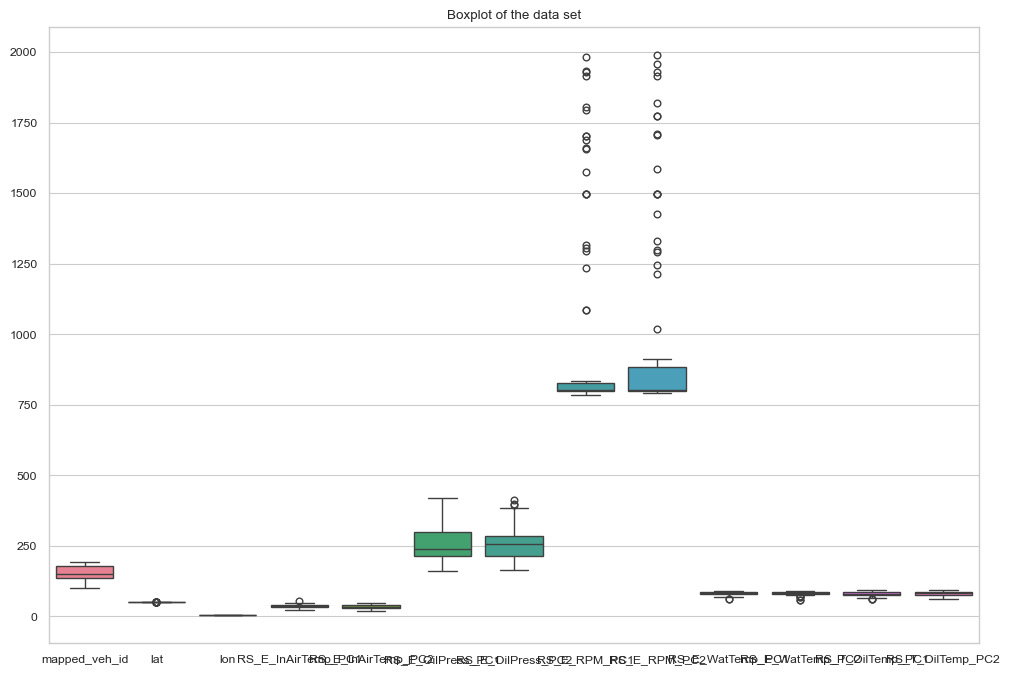

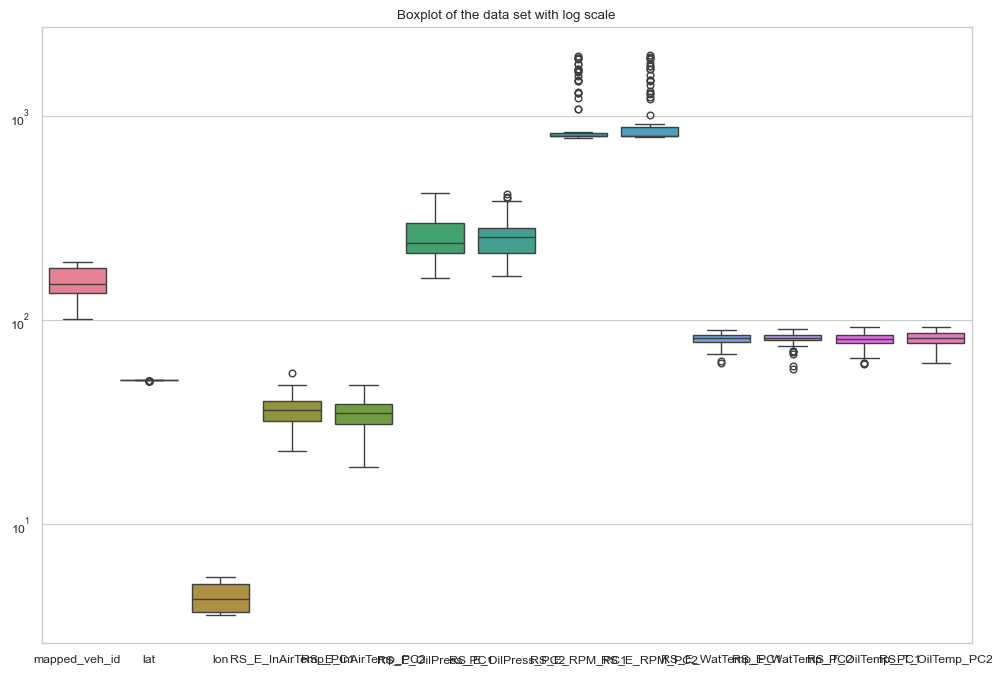

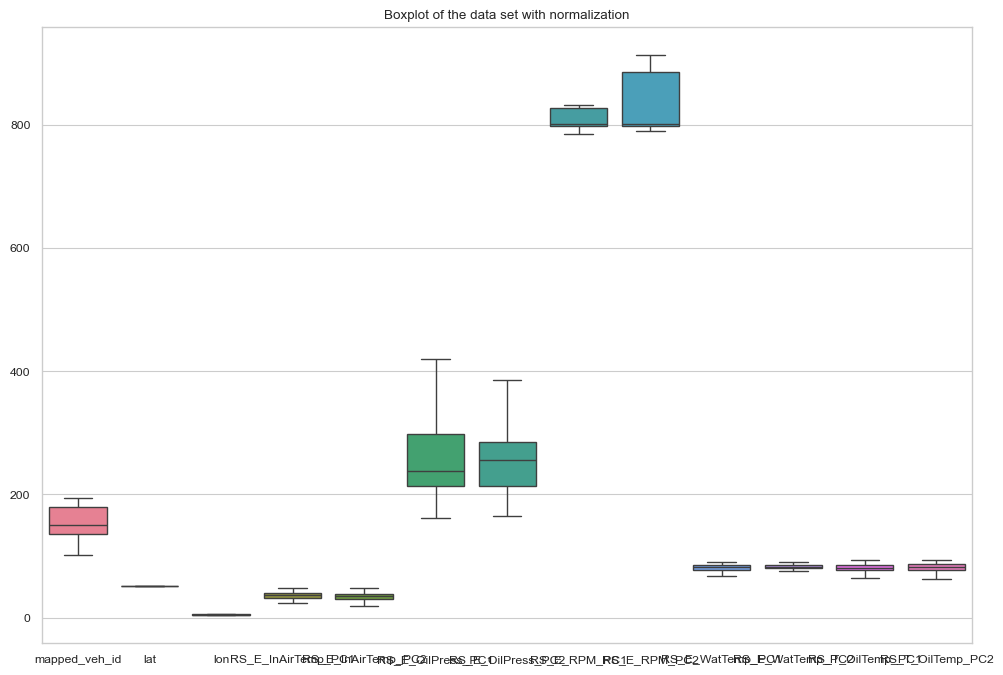

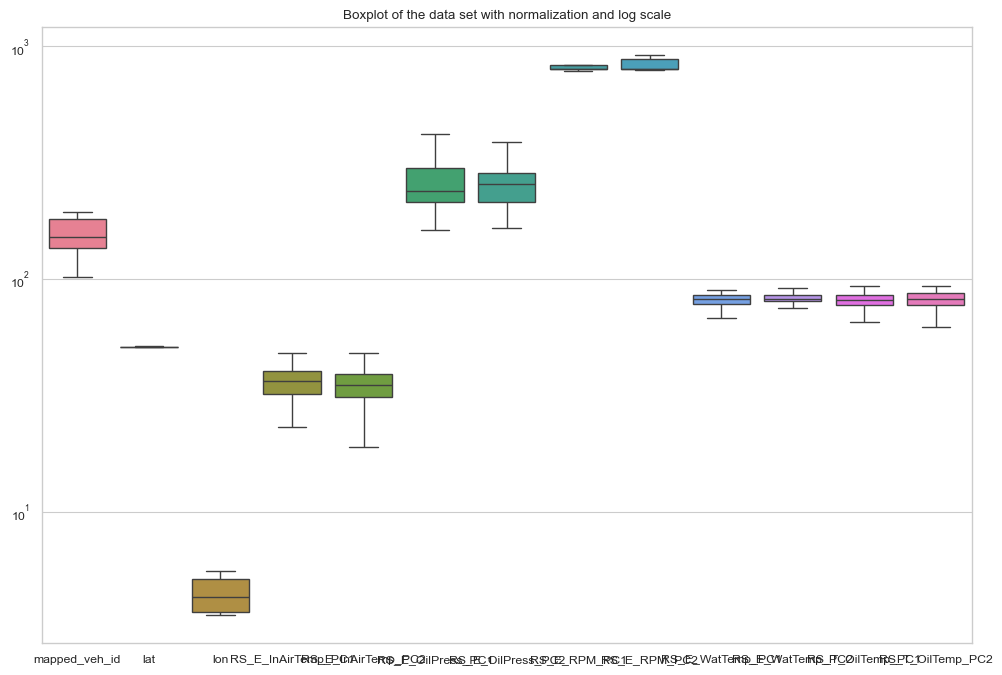

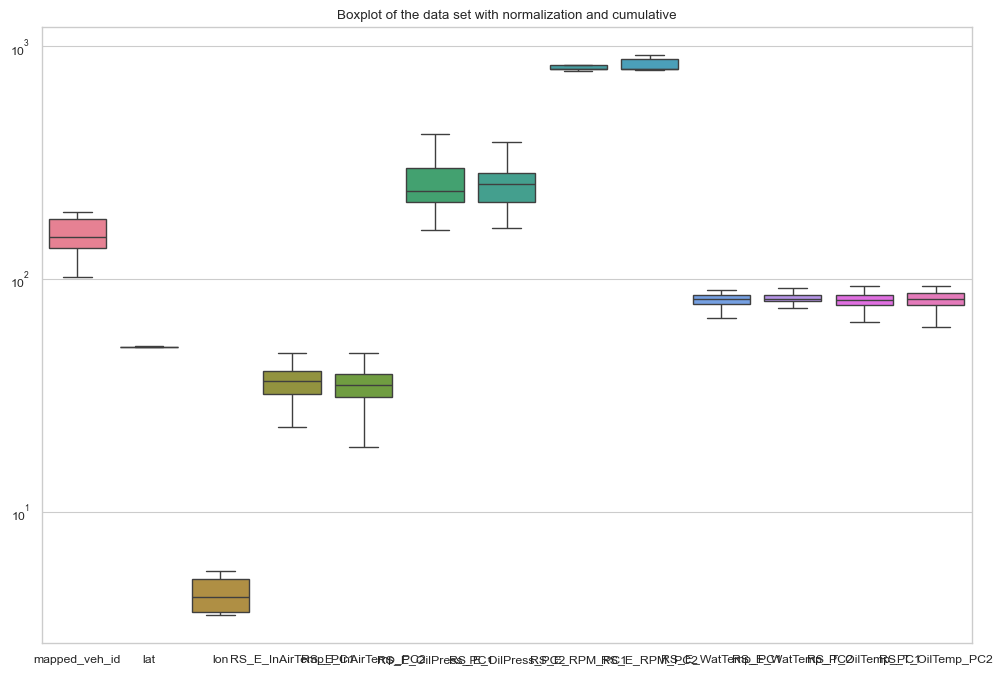

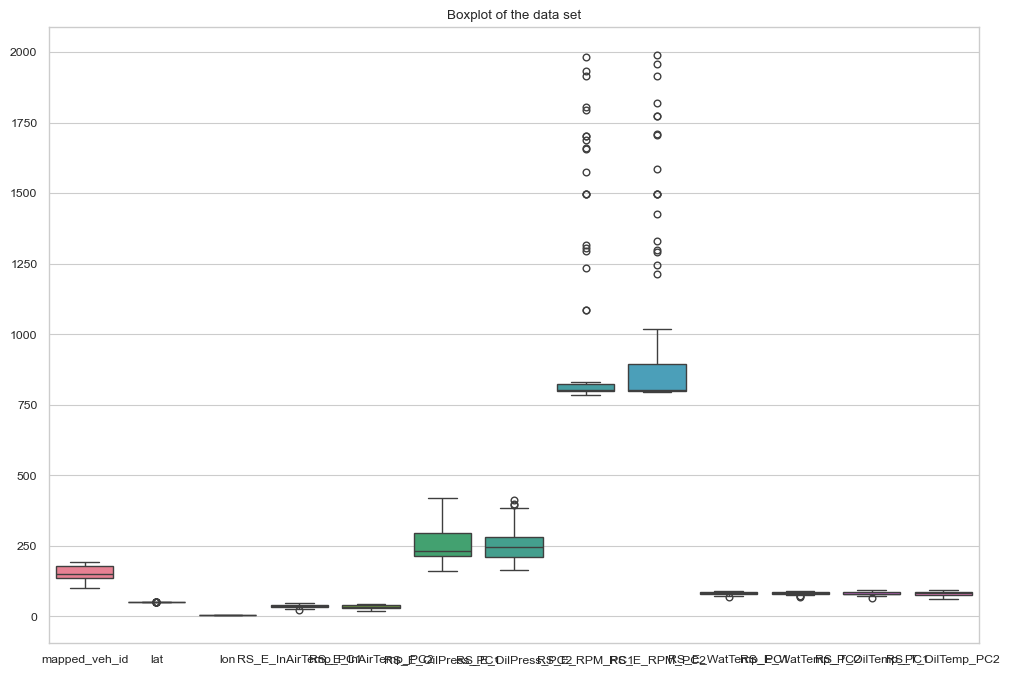

In [39]:
# let's perform preprocessing
# first convert the timestamps_UTC column to datetime 
df['timestamps_UTC'] = pd.to_datetime(df['timestamps_UTC'])
# let's check for missing values

# let's plot the boxplots of the data set
sns.boxplot(data=df)
plt.title('Boxplot of the data set')
plt.show()

# let's plot the boxplots of the data set with log scale
sns.boxplot(data=df)
plt.title('Boxplot of the data set with log scale')
plt.yscale('log')
plt.show()

# let's plot the boxplots of the data set with normalization
sns.boxplot(data=df, showfliers=False)
plt.title('Boxplot of the data set with normalization')
plt.show()

# let's plot the boxplots of the data set with normalization and log scale
sns.boxplot(data=df, showfliers=False)
plt.title('Boxplot of the data set with normalization and log scale')
plt.yscale('log')
plt.show()

# let's plot the boxplots of the data set with normalization and cumulative
sns.boxplot(data=df, showfliers=False)
plt.title('Boxplot of the data set with normalization and cumulative')
plt.yscale('log')
plt.show()

# let's remove the outliers in df except for the timestamps_UTC column
df = df[(np.abs(stats.zscore(df.drop(columns=['timestamps_UTC']))) < 3).all(axis=1)]



# let's plot the boxplots of the data set
sns.boxplot(data=df)
plt.title('Boxplot of the data set')
plt.show()





In [ ]:
# shall aggregate before preprocessing? response : 

In [42]:
import requests
from datetime import datetime, timedelta

# Replace 'YOUR_API_KEY' with your OpenWeatherMap API key
api_key = 'faf50f911be9948c249bcb1a0756e97f'

# Specify the city and country code (e.g., 'City,CountryCode')
city_country = 'Brussels,BE'

# Specify the start and end timestamps
start_date = datetime(2023, 8, 1)
end_date = datetime(2023, 9, 1)

# OpenWeatherMap API endpoint for historical weather data
api_url = f'https://api.openweathermap.org/data/2.5/onecall/timemachine?lat=50.8503&lon=4.3517&appid={api_key}'

# Convert timestamps to UNIX timestamp format
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Add timestamps to the API request
api_url += f'&start={start_timestamp}&end={end_timestamp}'

# Add the city and country code to the API request
api_url += f'&q={city_country}'



# Make the API request
response = requests.get(api_url)
weather_data = response.json()

# Print the entire response to inspect its structure
print(weather_data)

# Now, navigate through the structure to identify the correct path to hourly temperature data
# For example, if temperature data is nested under 'hourly' -> 'temp', modify the next line accordingly
temperature_data = [entry['temp'] for entry in weather_data['hourly']]

# Print temperature data
print(temperature_data)

{'cod': '400', 'message': 'no location or time specified'}


KeyError: 'hourly'